In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pa
import librosa as lb
from IPython.display import Audio
import librosa.display

In [204]:
# Load the audio data
soundpath = "Recording.wav"
# Convert amplitudes to numpy array
data ,samplerate= lb.load(soundpath,sr=16000 )
data_series = pa.Series(data)

In [4]:
# Audio preview 
Audio(data= soundpath, rate=samplerate)

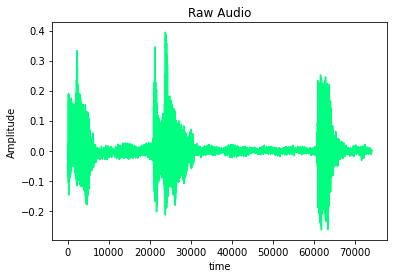

In [5]:
# Ampltitude Time plot of the loaded data
pa.Series(data).plot(title= "Raw Audio", colormap = "winter_r",xlabel="time",ylabel="Amplitude")
plt.show()

In [113]:
### Noise addition
# Add pure sinusoidal tones to the audio 
# Purpose for the tones are to mimic noise 
# Each noise has different durations, frequancy and amplitude to make the noise more complex 
# For better testing the filters effect 

## Parameters 

noise_freq=100 
# Relative reference of the frequancy of different pure tones
number_of_noise = 1                    
# How many different number of noise to add   
amplitude_adjust = 0.5
# Adjust the relative reference amplitude  -- higher the parameter lower the amplitude

tone_noise = []
tune_durations = [] 
# Store each noise array and duration into an array


dur = lb.get_duration(data) 
Noisy_Data = np.zeros(len(data))

for i in range (0,number_of_noise):
    tone_noise.append(    np.divide(librosa.tone(   frequency=noise_freq*(i+1), sr=samplerate, duration=dur)    ,  ((amplitude_adjust*(i+1)))) )

    tune_durations.append(len(tone_noise[i]))                                   
    #Store the duration which the noise have started

    dif_dur = (len( data)) - (len(tone_noise[i]))
    tone_noise[i] = np.append(tone_noise[i] , np.zeros(dif_dur))
    #Append zeros to fill the array -- needed for array addition

for i in range (0,1):
    Noisy_Data = Noisy_Data + tone_noise[i]
Noisy_Data = data + Noisy_Data
#Add the noise


tone_noise_db = np.array(tone_noise[0]) 

C:\Users\Enes\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:21: FutureWarning: Pass y=[-1.4893857e-09  2.0148978e-09 -2.6290290e-09 ...  4.4671629e-06
 -1.2675259e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error


In [18]:
# Noisy Audio preview 
Audio(data=Noisy_Data , rate=samplerate)

In [19]:
## Array Initiation

weigt_array_dim = (1,2)   
µ = 0.001                        # Learning Rate      
w = np.zeros(weigt_array_dim[1]) # Weigth Matrix
e = np.zeros(weigt_array_dim[1]) 
y = np.zeros(weigt_array_dim[1])

In [226]:
## Basic Wiener Algorithm 

def updatecoeffs(w,µ ,e,x):
    e = float(e)
    x =  float(x)
  
    ## Note that: 
    # This formula was given in Li Tan's book 
    # My guess is it is arbitary 
    # Not a meangful formula for real life applications    
    return 2*µ*e*x   

def basic_Wiener_Filter(x,µ,x_noisy,e_storage):

    assert(type(x)== np.ndarray)
    #range (0,data.shape[0])
    weigt_array_dim = (1,2) 
    w = np.zeros(weigt_array_dim[1]) #Weigth Matrix
    
    e = np.zeros(weigt_array_dim[1])
    #Input x has two dimension  { Time-Amplitude/ Frequancy-Magniutde }
    y = np.zeros(weigt_array_dim[1])
    #print(len(x),len(x_noisy))
    for i in range (0,x.shape[0]):
        y[0] = w[0]*x_noisy[i] 
        y[1] = w[1]*x_noisy[i] 

        e[0] = x[i] - µ*y[0]
        e[1] = x[i] - µ*y[1]
       
        #To anaylse data
        e_storage[0].append(e[0])
        e_storage[1].append(e[1])

        y_storage[0].append(y[0])
        y_storage[1].append(y[1])


        w[0] =  w[0]+   2*µ*e[0]*x[i]
        w[1] =  w[1]+   updatecoeffs(w[1],µ ,e[1],x[i])
        #print(w)

In [187]:
## Basic Wiener Algorithm equvalent to matlab tests
# Wiener 1 Test

def updatecoeffs_m(w,µ ,e,x):
    e = float(e)
    x =  float(x)
    return 2*µ*e*x

def basic_Wiener_Filter_Test_1(x,µ,x_noisy,e_storage):
    #Data type gave non
    
    assert(type(x)== np.ndarray)
    time = len(x)
    numofweigths = 5
    w = np.zeros(numofweigths) 
    e = np.zeros(len(data))
    y = np.zeros(len(data))

    #Input x can have dimensions  { Time-Amplitude/ Frequancy-Magniutde }

    for i in range ((numofweigths),time):
        sum = 0
        for j in range (1,numofweigths):
            sum = sum+ w[j]*tone_noise_db[i-j] 

        y[i] = sum
        e[i] = x_noisy[i] - y[i]

        for k in range (0,numofweigths):
            w[k] =  w[k]+   2*µ*e[i]*x[i-k]
    
    return e,y,w

In [190]:
# Wiener 1 Test
# Matlab test on python 

data_small    = [1,4,5,8,9,10,11,12,9,8,7,10,11,12,9,8,7]
data_small  = np.array(data_small )
noise   = np.random.normal(0,1,len(data_small ))
noisy_data = np.add(noise , data_small )

e_storage = [[],[]]
e_storage[0], estimates_dnt , weights = basic_Wiener_Filter_Test_1(data_small ,0.001,noisy_data ,e_storage)

Text(0.5, 1.0, 'Clean input')

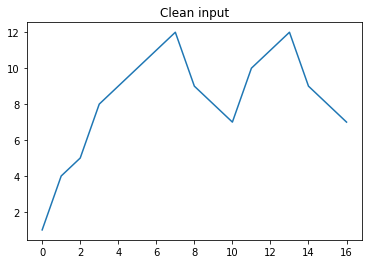

In [181]:
plt.plot(data)
plt.title("Clean input")

Text(0.5, 1.0, 'Curropted Input')

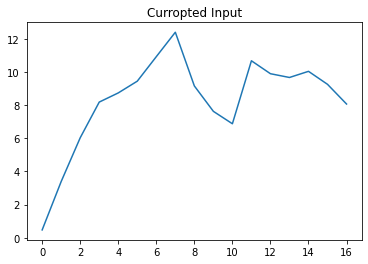

In [183]:
plt.plot(noisy_data)
plt.title("Curropted Input")

Text(0.5, 1.0, 'Clean Sİgnal Estimatation')

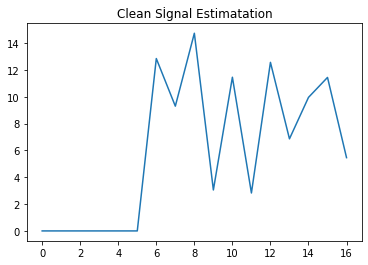

In [185]:
plt.plot(estimates_dnt)
plt.title("Clean Sİgnal Estimatation")

In [228]:
# Wiener 2 Test

# Amplitude to decibel conversion
Noisy_decibel = librosa.amplitude_to_db(Noisy_Data)
data_decibel = librosa.amplitude_to_db(data)
tone_noise_db = librosa.amplitude_to_db(tone_noise_db)
µ = 0.001                     #Learning Rate    

e_storage = [[],[]]
y_storage = [[],[]]

basic_Wiener_Filter(data_decibel,µ,Noisy_decibel,e_storage)

Text(0.5, 1.0, 'Corrupted Sound db')

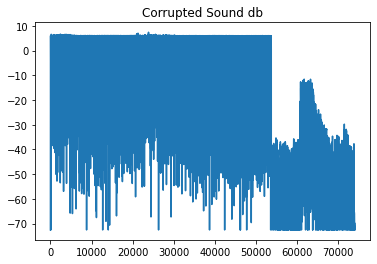

In [229]:
plt.plot(Noisy_decibel)
plt.title("Corrupted Sound db")

Text(0.5, 1.0, 'Clean Sound db')

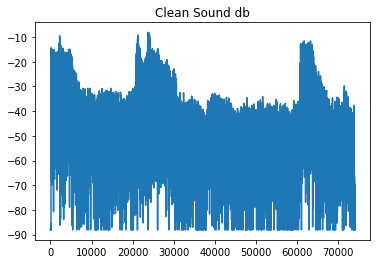

In [230]:
plt.plot(data_decibel)
plt.title("Clean Sound db")

Text(0.5, 1.0, 'Erorr Storage')

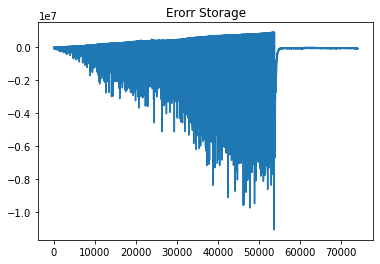

In [235]:
plt.plot(y_storage[1])
plt.title("Erorr Storage")

In [236]:
# Frequancy Domain analysis 
fft_noisy    = np.abs(np.fft.fft(Noisy_Data))
fft_original = np.abs(np.fft.fft(data))

In [242]:
e_storage_frequancy = [[],[]]
µ=0.005

# Frequancy Domain analysis
fft_noisy    = np.abs(np.fft.fft(Noisy_Data))
fft_original = np.abs(np.fft.fft(data))
basic_Wiener_Filter(fft_original[0:int(len(fft_original)/2)],µ,fft_noisy[0:int(len(fft_noisy)/2)],e_storage_frequancy)

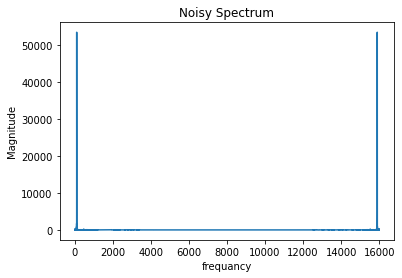

In [243]:
frequancy = np.linspace(0,samplerate,len(fft_noisy))
plt.plot(frequancy,fft_noisy)
plt.ylabel("Magnitude")
plt.xlabel("frequancy")
plt.title("Noisy Spectrum")
plt.show()

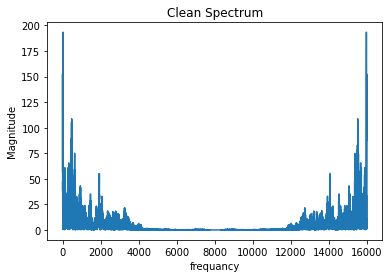

In [244]:
frequancy = np.linspace(0,samplerate,len(fft_original))
plt.plot(frequancy,fft_original)
plt.ylabel("Magnitude")
plt.xlabel("frequancy")
plt.title("Clean Spectrum")
plt.show()

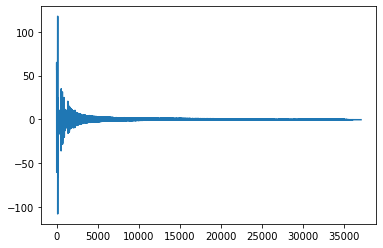

In [245]:
plt.plot(e_storage_frequancy[0], label = "Erorr Storage")

In [420]:
# Generetae a noise -- Have small range     -- Have Sudden amplitude increase   --Increase the range to see if filter can adapt 

In [241]:
## Undefined Noise havent testes
onset_env = librosa.onset.onset_strength(y=data, sr=samplerate, max_size=5)
onset_times = librosa.onset.onset_detect(onset_envelope=onset_env, sr=samplerate, units='time')
y_clicks = librosa.clicks(times=onset_times, length=len(data), sr=samplerate)

Noisy_Data_1 = data+y_clicks
Audio(data=Noisy_Data_1 , rate=samplerate)